In [2]:
from flightTools import Flight, thrust_parse
from trainingTools import FlightController
from numpy.linalg import norm
from numpy import array as A
from keras.layers import Dense
from keras.models import Sequential
from plotTools import FlightAnimation, flight_data_plot
from IPython.display import HTML
import matplotlib.pyplot as plt
import numpy as np

To begin we're going to train only on mode=0 (no horizontal motion). Before we can run a single flight we need two things:
* A _model_ (the neural network itself) which takes the current state of the flight as input and outputs a score for each possible decision. The Flight Controller will make the decision with the highest score.
* A _reward function_ which takes the current state of the flight and assigns a reward based on how the flight has changed since the previous timestep. Improvements give positive rewards, a deterioration gives a negative reward.

___
### 1. Building the Neural Network
This is your first task, designing a network that can safely land the rocket. There is a tradeoff between accuracy and speed here. A large network will be able to handle more complicated and diverse scenarios but will take _much_ longer to train.

In [4]:
# Say how many inputs and outputs we need
input_size, output_size = 2, 2

`Sequential` is the basic network type in `Keras`. It consists of sequential layers of neurons which we add one-by-one.

`Dense` is the basic _layer_ type in `Keras`. It consists of $N$ neurons. It's a _dense_ layer because every neuron is connected to every neuron in both the previous and subsequent layers, if they're present.

__The model as below would not be suitable for training on our problem__

In [20]:
model = Sequential()

# First layer: two inputs and two outputs
model.add(Dense(2, input_shape=(input_size,), activation='tanh'))

# Second layer: two inputs (keras works that out from the previous layer) and two outputs, linear act. function
model.add(Dense(output_size, activation='linear'))

# Finally compile the model ready for training
model.compile(optimizer='adam', loss='mse')

We can print the network structure and see the first layer has two outputs, the second also has two. With 4 neurons there are 12 parameters to train, this is already a lot! Compare that with e.g. finding a line of best fit in the lab where there are only two parameters to train.

In [7]:
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 2)                 6         
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 6         
Total params: 12
Trainable params: 12
Non-trainable params: 0
_________________________________________________________________
None


___
### 2. Assigning a Reward Function
Now we have the network we must decide how to reward/penalise its decisions. Below is a very basic template that you can modify. The function should take the flight object as its only input and return a number for the reward. You can access the properties of the flight as _attributes_. I.e:
* `flight.status[-1]` is the current status of the flight (see flightTools.Flight.status_check())
* `flight.position[-1]` is the current position vector relative to the landing pad and `flight.position[-2]` is the previous position. Compare these to see if it improved.
Look at the code in `flightTools.Flight` to see the full list of attributes you can access.

Remember the positions/velocities etc can take large values but the NN works best when its inputs are scaled to be within $[-1, 1]$ or close enough, fractions are good for this.

In [8]:
# This simply rewards moving closer to the launchpad
# The score is just the fractional decrease in distance, compared to previous timestep
def reward_function(flight):
    
    # Initialise
    reward = 0.0
    
    # Give a reward equal to the (negative) difference in position, moving lower gives more reward
    reward -= (flight.position[-1][1] - flight.position[-2][1])

    # If the rocket lands successfully give an extra bonus
    if flight.status[-1] == 2:
        reward += 50.0
    
    # Give a penalty if the rocket crashes
    elif abs(flight.status[-1]) == 1:
        reward -= 50.0
    
    return reward

___
### 3. A Test Flight
First we initialise a FlightController object (see `trainingTools.FlightController`). This object interfaces between the flight itself and the training. I'll explain some of its features as we go. All it needs to start is the input/output size and the model that we've chosen to use (see above).

In [15]:
flight_controller = FlightController(input_size, output_size, model)

Now we can initialise the flight. The `Flight` object (see `flightTools.Flight` just sets up the flight. We can then do `flight.update()` to move the flight forward by one timestep, or `flight.run()` to run the flight until it crashes/lands/runs out of time.

In [16]:
flight = Flight(flight_controller=flight_controller, 
                reward_function=reward_function, mode=0)

In [17]:
flight.run()

 T: 07.40 | Crashed

To plot the outcome of an individual flight we use the functions in `plotTools`. `flight_data_plot` will plot the statistics of the flight as a function of time. We can see the NN is acting randomly at this point.

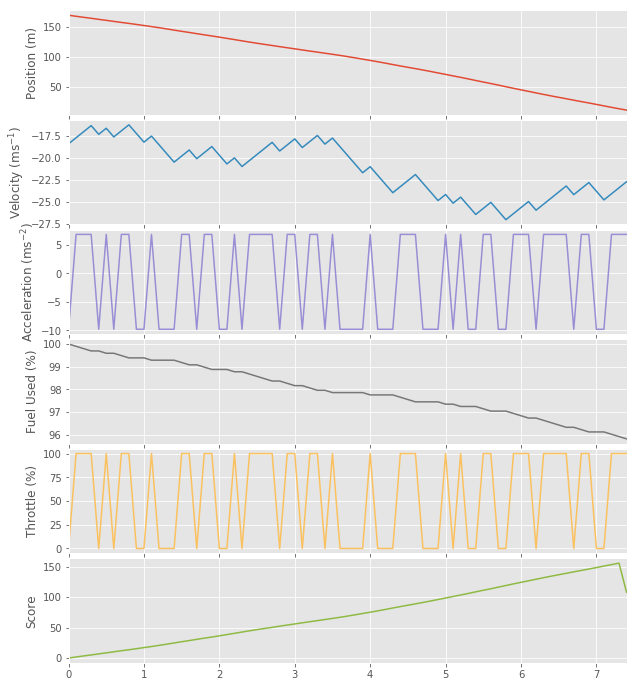

In [18]:
flight_data_plot(flight)
plt.show()

`FlightAnimation` will create a video of the flight in real time like so...

In [19]:
%%capture
# The %%capture is some notebook code that stops the final frame being displayed.
file_name = './test_clip.mp4'
FlightAnimation(flight, file_name)

Which you can view in the file browser or inside the notebook by running some HTML:

In [14]:
HTML("<video width='800' height='800' autoplay> <source src='%s' type='video/mp4'> </video>" %
     file_name)

___
### 4. Training
Okay now we train our model. The process is below, I'll try and explain each line:

In [23]:
# The mode we're using
mode = 0

# The number of flights we'll run
episodes = 100000

# The number of moves (not flights) on which to train the model in batches
batch_size = 50

In [24]:
# The flight controller we're going to train
flight_controller = FlightController(input_size, output_size, model)

# The reward function we will use
reward_function = reward_function

In [ ]:
for i in range(episodes):
    
    # Initialise a new flight. This randomises the initial conditions each time
    flight = Flight(flight_controller=flight_controller, 
                    reward_function=reward_function, mode=mode)
    
    # Get the initital state vector
    done, total_reward = False, 0
    state = A([flight.state_vector(mode)])
    
    # Update the flight until it crashes
    while not done:

        # Get the action from the flight controller
        action = flight_controller(state)
        
        # Update the flight and get the reward and the new state
        next_state, reward, done = flight.update(action)
        
        # Add the reward from the previous step to the total
        total_reward += reward
        
        # Transform the state vector (Keras only takes 2D)
        next_state = np.reshape(next_state, [1, input_size])
        
        # Commit this iteration to the memory
        flight_controller.remember(state, action, reward, next_state, done)
        state = next_state
        
        # When the flight is over...
        if done:

            # Print and save the results every 50th flight (maybe change this)
            if i % 500 == 0:

                print("\r", "{:6d}/{:6d}, {:8s}, score: {: 3.2f}, e: {:3.2f}".format(
                    i, episodes, flight.status_string(), total_reward, flight_controller.epsilon
                ))
                plt.close('all')
                
                # Make an animation of the flight so we can check progress
                FlightAnimation(flight, './plots/%06d.mp4' % i)
                
                # Save the weights so we can start training from here
                flight_controller.save('./weights/weights_%06d.h5' % i)
                break

    # When there are enough saved moves, start training each
    # time a new flight completes
    if len(flight_controller.memory) > batch_size:
        flight_controller.replay(batch_size)

      0/100000, Crashed , score:  108.38, e: 1.00
